In [42]:
import torch
import clip
import time
import shutil
import math
import random

import numpy as np
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision.datasets as datasets

import torch.nn as nn
import torch.optim as optim
import torch.utils.data


torch.cuda.is_available()


start_epoch = 0
epochs = 200
batch_size = 32
lr = 30
print_frequency = 10


class MLP(nn.Module):
    def __init__(self, dim):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(dim, 128)
        self.BN1 = nn.BatchNorm1d(128)
        self.out = nn.Linear(128, 2)
        self.BN2 = nn.BatchNorm1d(2)
        
    def forward(self, x):
        x = x.to(torch.float32)
        x = self.BN1(self.hidden1(x))
        x = F.relu(x)
        x = self.BN2(self.out(x))
        return x

class myMoCo(nn.Module):
    def __init__(self):
        super(myMoCo, self).__init__()
        
        self.pos = 4 #the number of positive samples
        
        self.indim = 512
        self.outdim = 2
        self.m = 0.999
        self.T = 0.07
        self.K = 128*(self.pos-1)
        
        self.mlp_q = MLP(self.indim).cuda()
        self.mlp_k = MLP(self.indim).cuda()
        for param_q, param_k in zip(self.mlp_q.parameters(), self.mlp_k.parameters()):
            param_k.data.copy_(param_q.data) #initialize key MLP
            param_k.required_grad = False
        
        self.register_buffer("queue", torch.randn(self.outdim, self.K))
        self.queue = nn.functional.normalize(self.queue, dim=0)
        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))   
        
    """
    input_q : Batch x feat_size == N x inDim
    input_k : (Batch x pos_pairs) x feat_size == (N x J) x inDim ==> M x inDim
    """ 
    def forward(self, pos_pairs):
        input_q = pos_pairs[:,:1,:] #N x 1  x inDim
        input_q = input_q.squeeze() #N x inDim
        input_q = nn.functional.normalize(input_q, dim=1)
        
        q = self.mlp_q(input_q) # N x outDim
        q = nn.functional.normalize(q, dim=1)
        
        with torch.no_grad():
            input_k = pos_pairs[:,1:,:] #N x J x inDim
            N = input_k.shape[0]
            J = input_k.shape[1]
            input_k = torch.reshape(input_k, (-1, self.indim)) # reshape : (N x J) x inDim ==> M x inDim
            input_k = nn.functional.normalize(input_k, dim=1)
            
            k = self.mlp_k(input_k) # M x outDim
            k = nn.functional.normalize(k, dim=1)
            
            k = torch.reshape(k, (N, -1, self.outdim)) # undo reshape : M x outDim ==>(N x J) x outDim
        
        loss_pos = torch.einsum("nc,njc->n", [q, k]).unsqueeze(-1) # N x 1
        #loss_pos /= self.pos-1
        
        loss_neg = torch.einsum("nc,ck->nk", [q, self.queue.clone().detach()]) # N x K
        
        logits = torch.cat([loss_pos, loss_neg], dim=1) # N x (1+K)
        logits /= self.T
        
        labels = torch.zeros(logits.shape[0], dtype=torch.long).cuda()
        
        self._dequeue_and_enqueue(k)
        
        return logits, labels
    
    
    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        for param_q, param_k in zip(self.mlp_q.parameters(), self.mlp_k.parameters()):
            param_k.data = param_k.data*self.m + param_q.data*(1.0-self.m)
        
    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
#         chosen = random.randint(0, self.pos-2)
#         keys = keys[:, chosen, :].squeeze() #chose one view: N x J x C ==> N x 1 x C ==> N x C
        keys = torch.reshape(keys, (-1, self.outdim))
        M = keys.shape[0]
        ptr = int(self.queue_ptr)
        self.queue[:, ptr : ptr + M] = keys.T
        ptr = (ptr + M) % self.K
        self.queue_ptr[0] = ptr

def adjust_learning_rate(optimizer, epoch):
    lr = 1e-3
    lr *= 0.5 * (1.0 + math.cos(math.pi * epoch / epochs))
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


def save_checkpoint(state, is_best, filename):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, "model_best.pth.tar")


def train(train_loader, model, criterion, optimizer, epoch):
    for i, pos_pairs in enumerate(train_loader):
        
        output, target = model(pos_pairs)
        loss = criterion(output, target)
       
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print('Epoch[{0}]    Iter[{1}/8]    Loss: {2}'.format(epoch+1, i+1, loss))
        

def main():
    
    model = myMoCo().cuda()
    criterion = nn.CrossEntropyLoss().cuda()
    optimizer = optim.SGD(
        model.parameters(), 
        lr = 1e-3,
        momentum = 0.9,
        weight_decay = 1e-4
    )
    
    """
    # optionally resume from a checkpoint
    ...
    """
    
    cudnn.benchmark = True
    
    train_file = '../CUHK01/dataset.pkl'
    N = 256
    B = 32
    
    train_dataset = torch.load(train_file).cuda()
    train_dataset = train_dataset[:N]
    
    trainloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size = B,
        shuffle = True
    )
    
    for epoch in range(start_epoch, epochs):
        
        adjust_learning_rate(optimizer, epoch)
        train(trainloader, model, criterion, optimizer, epoch)
        
        print('\n\n')
        
        torch.save(model.mlp_q.state_dict(), './pretrained/MLP/mlp{:04d}.pth.tar'.format(epoch+1))
        save_checkpoint(
            {
                "epoch": epoch + 1,
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
            },
            is_best=False,
            filename="./pretrained/myMoCo/checkpoint_{:04d}.pth.tar".format(epoch+1),
        )


main()
print('DONE!')

Epoch[1]    Iter[1/8]    Loss: 11.419350624084473
Epoch[1]    Iter[2/8]    Loss: 11.731765747070312
Epoch[1]    Iter[3/8]    Loss: 12.989677429199219
Epoch[1]    Iter[4/8]    Loss: 20.275188446044922
Epoch[1]    Iter[5/8]    Loss: 14.527023315429688
Epoch[1]    Iter[6/8]    Loss: 12.218132019042969
Epoch[1]    Iter[7/8]    Loss: 20.444358825683594
Epoch[1]    Iter[8/8]    Loss: 16.2563419342041



Epoch[2]    Iter[1/8]    Loss: 14.282427787780762
Epoch[2]    Iter[2/8]    Loss: 13.53307056427002
Epoch[2]    Iter[3/8]    Loss: 14.4962739944458
Epoch[2]    Iter[4/8]    Loss: 10.5419340133667
Epoch[2]    Iter[5/8]    Loss: 7.451063632965088
Epoch[2]    Iter[6/8]    Loss: 13.941946983337402
Epoch[2]    Iter[7/8]    Loss: 9.920350074768066
Epoch[2]    Iter[8/8]    Loss: 9.389582633972168



Epoch[3]    Iter[1/8]    Loss: 11.524247169494629
Epoch[3]    Iter[2/8]    Loss: 8.866131782531738
Epoch[3]    Iter[3/8]    Loss: 9.265400886535645
Epoch[3]    Iter[4/8]    Loss: 8.776235580444336
Epoch[3

Epoch[22]    Iter[1/8]    Loss: 3.9450466632843018
Epoch[22]    Iter[2/8]    Loss: 6.207179546356201
Epoch[22]    Iter[3/8]    Loss: 4.885985851287842
Epoch[22]    Iter[4/8]    Loss: 3.8539671897888184
Epoch[22]    Iter[5/8]    Loss: 2.884986400604248
Epoch[22]    Iter[6/8]    Loss: 3.602705240249634
Epoch[22]    Iter[7/8]    Loss: 3.7185373306274414
Epoch[22]    Iter[8/8]    Loss: 2.416100025177002



Epoch[23]    Iter[1/8]    Loss: 4.2934184074401855
Epoch[23]    Iter[2/8]    Loss: 3.189650774002075
Epoch[23]    Iter[3/8]    Loss: 4.554028034210205
Epoch[23]    Iter[4/8]    Loss: 3.930598735809326
Epoch[23]    Iter[5/8]    Loss: 3.60500168800354
Epoch[23]    Iter[6/8]    Loss: 4.579772472381592
Epoch[23]    Iter[7/8]    Loss: 2.052419662475586
Epoch[23]    Iter[8/8]    Loss: 3.181356906890869



Epoch[24]    Iter[1/8]    Loss: 4.055753231048584
Epoch[24]    Iter[2/8]    Loss: 3.0134365558624268
Epoch[24]    Iter[3/8]    Loss: 3.4239978790283203
Epoch[24]    Iter[4/8]    Loss: 3.73025

Epoch[43]    Iter[1/8]    Loss: 3.3384835720062256
Epoch[43]    Iter[2/8]    Loss: 1.9874122142791748
Epoch[43]    Iter[3/8]    Loss: 0.8852978944778442
Epoch[43]    Iter[4/8]    Loss: 2.2325477600097656
Epoch[43]    Iter[5/8]    Loss: 1.815727949142456
Epoch[43]    Iter[6/8]    Loss: 4.216632843017578
Epoch[43]    Iter[7/8]    Loss: 1.8190420866012573
Epoch[43]    Iter[8/8]    Loss: 2.4963135719299316



Epoch[44]    Iter[1/8]    Loss: 3.1881730556488037
Epoch[44]    Iter[2/8]    Loss: 3.304738998413086
Epoch[44]    Iter[3/8]    Loss: 2.5891849994659424
Epoch[44]    Iter[4/8]    Loss: 1.4239287376403809
Epoch[44]    Iter[5/8]    Loss: 2.6559367179870605
Epoch[44]    Iter[6/8]    Loss: 1.8914580345153809
Epoch[44]    Iter[7/8]    Loss: 1.5068784952163696
Epoch[44]    Iter[8/8]    Loss: 2.3820436000823975



Epoch[45]    Iter[1/8]    Loss: 1.673474669456482
Epoch[45]    Iter[2/8]    Loss: 2.582425832748413
Epoch[45]    Iter[3/8]    Loss: 2.830544948577881
Epoch[45]    Iter[4/8]    Loss:

Epoch[63]    Iter[4/8]    Loss: 0.9955636858940125
Epoch[63]    Iter[5/8]    Loss: 2.70430850982666
Epoch[63]    Iter[6/8]    Loss: 1.933624505996704
Epoch[63]    Iter[7/8]    Loss: 2.3857877254486084
Epoch[63]    Iter[8/8]    Loss: 1.3921940326690674



Epoch[64]    Iter[1/8]    Loss: 1.8198102712631226
Epoch[64]    Iter[2/8]    Loss: 2.7821993827819824
Epoch[64]    Iter[3/8]    Loss: 1.6289844512939453
Epoch[64]    Iter[4/8]    Loss: 2.079954147338867
Epoch[64]    Iter[5/8]    Loss: 1.6929068565368652
Epoch[64]    Iter[6/8]    Loss: 1.985791802406311
Epoch[64]    Iter[7/8]    Loss: 1.9165143966674805
Epoch[64]    Iter[8/8]    Loss: 2.393604040145874



Epoch[65]    Iter[1/8]    Loss: 0.9362380504608154
Epoch[65]    Iter[2/8]    Loss: 2.289111614227295
Epoch[65]    Iter[3/8]    Loss: 2.4539377689361572
Epoch[65]    Iter[4/8]    Loss: 1.0252559185028076
Epoch[65]    Iter[5/8]    Loss: 1.9078819751739502
Epoch[65]    Iter[6/8]    Loss: 2.973712921142578
Epoch[65]    Iter[7/8]    Loss: 2

Epoch[84]    Iter[1/8]    Loss: 2.985089063644409
Epoch[84]    Iter[2/8]    Loss: 1.3572291135787964
Epoch[84]    Iter[3/8]    Loss: 1.9768962860107422
Epoch[84]    Iter[4/8]    Loss: 2.619826555252075
Epoch[84]    Iter[5/8]    Loss: 1.9367032051086426
Epoch[84]    Iter[6/8]    Loss: 2.2709193229675293
Epoch[84]    Iter[7/8]    Loss: 2.4507362842559814
Epoch[84]    Iter[8/8]    Loss: 1.6835869550704956



Epoch[85]    Iter[1/8]    Loss: 0.9516758918762207
Epoch[85]    Iter[2/8]    Loss: 1.925577998161316
Epoch[85]    Iter[3/8]    Loss: 1.2217357158660889
Epoch[85]    Iter[4/8]    Loss: 1.7025610208511353
Epoch[85]    Iter[5/8]    Loss: 1.957448959350586
Epoch[85]    Iter[6/8]    Loss: 1.9216426610946655
Epoch[85]    Iter[7/8]    Loss: 3.0103461742401123
Epoch[85]    Iter[8/8]    Loss: 1.9194939136505127



Epoch[86]    Iter[1/8]    Loss: 2.0237622261047363
Epoch[86]    Iter[2/8]    Loss: 1.535793423652649
Epoch[86]    Iter[3/8]    Loss: 1.4759918451309204
Epoch[86]    Iter[4/8]    Loss

Epoch[105]    Iter[1/8]    Loss: 1.7633644342422485
Epoch[105]    Iter[2/8]    Loss: 1.5738725662231445
Epoch[105]    Iter[3/8]    Loss: 3.3713934421539307
Epoch[105]    Iter[4/8]    Loss: 1.2508563995361328
Epoch[105]    Iter[5/8]    Loss: 2.009774923324585
Epoch[105]    Iter[6/8]    Loss: 2.1852641105651855
Epoch[105]    Iter[7/8]    Loss: 2.315924882888794
Epoch[105]    Iter[8/8]    Loss: 2.493562698364258



Epoch[106]    Iter[1/8]    Loss: 1.388044834136963
Epoch[106]    Iter[2/8]    Loss: 2.1105828285217285
Epoch[106]    Iter[3/8]    Loss: 1.8165714740753174
Epoch[106]    Iter[4/8]    Loss: 2.765956163406372
Epoch[106]    Iter[5/8]    Loss: 1.9344974756240845
Epoch[106]    Iter[6/8]    Loss: 2.5316500663757324
Epoch[106]    Iter[7/8]    Loss: 2.5886030197143555
Epoch[106]    Iter[8/8]    Loss: 2.4130210876464844



Epoch[107]    Iter[1/8]    Loss: 2.2359254360198975
Epoch[107]    Iter[2/8]    Loss: 1.467464566230774
Epoch[107]    Iter[3/8]    Loss: 3.4829087257385254
Epoch[107]  

Epoch[126]    Iter[6/8]    Loss: 0.8833619356155396
Epoch[126]    Iter[7/8]    Loss: 1.7552661895751953
Epoch[126]    Iter[8/8]    Loss: 2.0804903507232666



Epoch[127]    Iter[1/8]    Loss: 1.1784024238586426
Epoch[127]    Iter[2/8]    Loss: 3.1544318199157715
Epoch[127]    Iter[3/8]    Loss: 1.9381300210952759
Epoch[127]    Iter[4/8]    Loss: 2.4813480377197266
Epoch[127]    Iter[5/8]    Loss: 1.4884686470031738
Epoch[127]    Iter[6/8]    Loss: 0.9016596674919128
Epoch[127]    Iter[7/8]    Loss: 2.009922742843628
Epoch[127]    Iter[8/8]    Loss: 2.8850598335266113



Epoch[128]    Iter[1/8]    Loss: 1.5231139659881592
Epoch[128]    Iter[2/8]    Loss: 1.5368850231170654
Epoch[128]    Iter[3/8]    Loss: 2.4952595233917236
Epoch[128]    Iter[4/8]    Loss: 1.1793664693832397
Epoch[128]    Iter[5/8]    Loss: 2.578260898590088
Epoch[128]    Iter[6/8]    Loss: 1.0315498113632202
Epoch[128]    Iter[7/8]    Loss: 1.8355988264083862
Epoch[128]    Iter[8/8]    Loss: 2.1699862480163574



Epoch

Epoch[148]    Iter[6/8]    Loss: 1.8839926719665527
Epoch[148]    Iter[7/8]    Loss: 1.7482110261917114
Epoch[148]    Iter[8/8]    Loss: 2.3680577278137207



Epoch[149]    Iter[1/8]    Loss: 0.5876433253288269
Epoch[149]    Iter[2/8]    Loss: 4.154400825500488
Epoch[149]    Iter[3/8]    Loss: 1.1210391521453857
Epoch[149]    Iter[4/8]    Loss: 2.3641457557678223
Epoch[149]    Iter[5/8]    Loss: 2.1843533515930176
Epoch[149]    Iter[6/8]    Loss: 1.189515233039856
Epoch[149]    Iter[7/8]    Loss: 2.1730129718780518
Epoch[149]    Iter[8/8]    Loss: 3.021238327026367



Epoch[150]    Iter[1/8]    Loss: 1.3743175268173218
Epoch[150]    Iter[2/8]    Loss: 0.9994546175003052
Epoch[150]    Iter[3/8]    Loss: 2.855365514755249
Epoch[150]    Iter[4/8]    Loss: 1.4452011585235596
Epoch[150]    Iter[5/8]    Loss: 2.4791691303253174
Epoch[150]    Iter[6/8]    Loss: 1.2109529972076416
Epoch[150]    Iter[7/8]    Loss: 2.2784829139709473
Epoch[150]    Iter[8/8]    Loss: 1.5089306831359863



Epoch[1

Epoch[171]    Iter[1/8]    Loss: 1.1347182989120483
Epoch[171]    Iter[2/8]    Loss: 1.3525989055633545
Epoch[171]    Iter[3/8]    Loss: 1.3472037315368652
Epoch[171]    Iter[4/8]    Loss: 1.1288731098175049
Epoch[171]    Iter[5/8]    Loss: 3.198843240737915
Epoch[171]    Iter[6/8]    Loss: 2.2045559883117676
Epoch[171]    Iter[7/8]    Loss: 1.638844609260559
Epoch[171]    Iter[8/8]    Loss: 2.8683810234069824



Epoch[172]    Iter[1/8]    Loss: 2.211190700531006
Epoch[172]    Iter[2/8]    Loss: 2.630248546600342
Epoch[172]    Iter[3/8]    Loss: 1.5253361463546753
Epoch[172]    Iter[4/8]    Loss: 2.7381560802459717
Epoch[172]    Iter[5/8]    Loss: 1.7827566862106323
Epoch[172]    Iter[6/8]    Loss: 2.442927598953247
Epoch[172]    Iter[7/8]    Loss: 0.7553732395172119
Epoch[172]    Iter[8/8]    Loss: 0.8681746125221252



Epoch[173]    Iter[1/8]    Loss: 2.2986514568328857
Epoch[173]    Iter[2/8]    Loss: 1.8892943859100342
Epoch[173]    Iter[3/8]    Loss: 2.7578744888305664
Epoch[173] 

Epoch[192]    Iter[6/8]    Loss: 1.4905844926834106
Epoch[192]    Iter[7/8]    Loss: 2.0119972229003906
Epoch[192]    Iter[8/8]    Loss: 4.383143424987793



Epoch[193]    Iter[1/8]    Loss: 2.671276092529297
Epoch[193]    Iter[2/8]    Loss: 2.147272825241089
Epoch[193]    Iter[3/8]    Loss: 1.9635593891143799
Epoch[193]    Iter[4/8]    Loss: 1.9312410354614258
Epoch[193]    Iter[5/8]    Loss: 1.5614889860153198
Epoch[193]    Iter[6/8]    Loss: 2.1607961654663086
Epoch[193]    Iter[7/8]    Loss: 1.896787166595459
Epoch[193]    Iter[8/8]    Loss: 2.668301582336426



Epoch[194]    Iter[1/8]    Loss: 1.8477468490600586
Epoch[194]    Iter[2/8]    Loss: 1.3903987407684326
Epoch[194]    Iter[3/8]    Loss: 1.573323369026184
Epoch[194]    Iter[4/8]    Loss: 1.8837010860443115
Epoch[194]    Iter[5/8]    Loss: 2.413146734237671
Epoch[194]    Iter[6/8]    Loss: 2.068547487258911
Epoch[194]    Iter[7/8]    Loss: 2.0258448123931885
Epoch[194]    Iter[8/8]    Loss: 2.0079329013824463



Epoch[195] 

torch.Size([101, 4, 512])


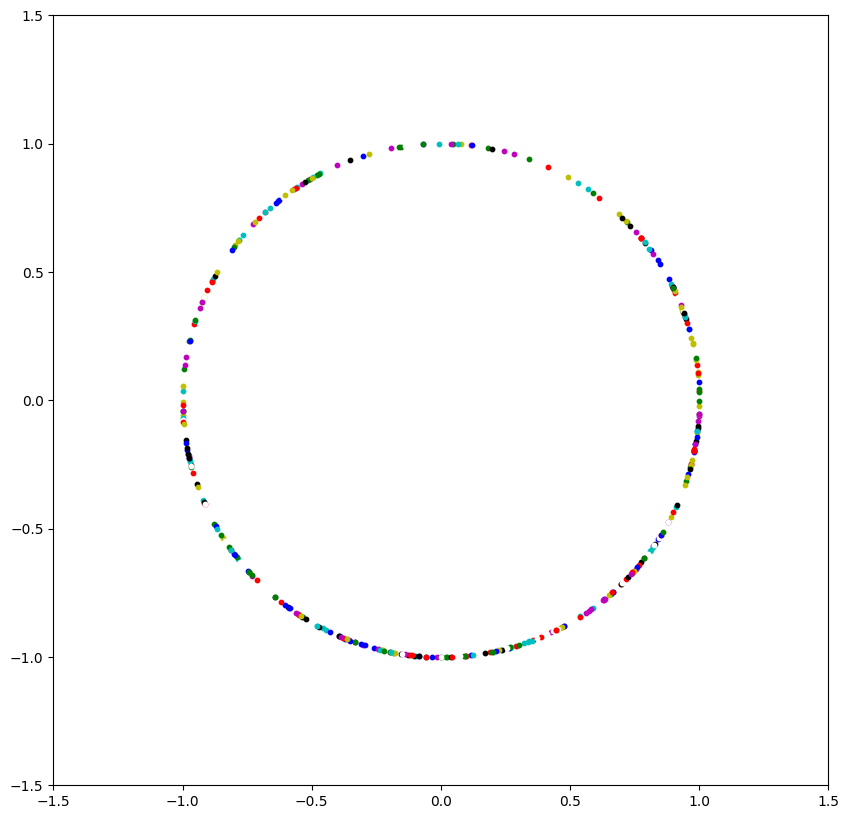

In [45]:
import matplotlib.pyplot as plt


def draw(x):

    color = ['r', 'y', 'b', 'g', 'c', 'm', 'k', 'w']
    ptr = 0
    
    fig = plt.figure(figsize=(10, 10))
    
    for pos in x:
        plt.scatter(pos.numpy()[:, 0], pos.numpy()[:, 1], c = color[ptr], s=10)
        ptr = (ptr+1)%len(color)
    
    plt.axis([-1.5, 1.5, -1.5, 1.5])
    plt.show()


weightdir = './pretrained/MLP/mlp0100.pth.tar'
weight = torch.load(weightdir)

mlp = MLP(512).cuda()
mlp.load_state_dict(weight)


path = '../CUHK01/dataset.pkl'
train_dataset = torch.load(path).cuda()

st = 0
end = 100
N = end-st+1
show_data = train_dataset[st:end+1]
inDim = show_data.shape[2]
print(show_data.shape)

inputs = show_data.reshape(-1, inDim)
outputs = mlp(inputs)
outputs = nn.functional.normalize(outputs, dim=1)
outputs = outputs.cpu().detach()

outDim = outputs.shape[1]
outputs = outputs.reshape(N, -1, outDim)
outputs.shape, outputs


draw(outputs)